<a href="https://colab.research.google.com/github/ameyas1/Graduate_admission_pytorch/blob/master/admission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torch import optim

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df=pd.read_csv('Admission_Predict.csv')

In [26]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [27]:
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [0]:
df.drop('Serial No.', inplace=True, axis=1)
df.rename({'GRE Score':'Gre_Score','TOEFL Score':'TOEFL_Score','Chance of Admit ': 'Chance_of_Admit', 'LOR ':'LOR','University Rating':'University_Rating'}, axis=1, inplace=True)

In [29]:
df.describe()

,Gre_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


Text(0.5, 1.0, 'Correlation Factors Heat Map')

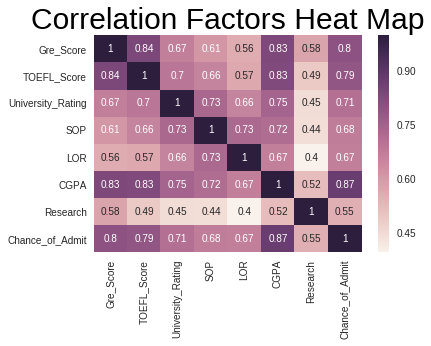

In [30]:
sns.heatmap(df.corr(), annot=True).set_title('Correlation Factors Heat Map', color='black', size='30')

In [0]:
cols=['Gre_Score','TOEFL_Score','University_Rating','SOP','LOR','CGPA','Research']
x=df[cols]
y=df[['Chance_of_Admit']]

In [0]:
from sklearn.model_selection import train_test_split
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.1)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_1_mod=scaler.fit_transform(x_1)
x_test_mod=scaler.transform(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [0]:
x_train_mod, x_val_mod, y_train, y_val = train_test_split(x_1_mod, y_1, test_size=0.1)

In [0]:
import torch.utils.data as data_utils
import torchvision.transforms as transforms


train = data_utils.TensorDataset(torch.Tensor(x_train_mod) , torch.Tensor(y_train.values.reshape(-1)))
train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)

In [0]:
test = data_utils.TensorDataset(torch.Tensor(x_test_mod) , torch.Tensor(np.array(y_test.values.reshape(-1))))
test_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

In [0]:
val = data_utils.TensorDataset(torch.Tensor(x_val_mod) , torch.Tensor(y_val.values.reshape(-1)))
val_loader = data_utils.DataLoader(val, batch_size=50, shuffle=True)

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(7, 8)
    self.hidden2 = nn.Linear(8, 5)
    self.output = nn.Linear(5, 1)
    self.dropout = nn.Dropout(0.2)
        
  def forward(self, x):
    x=self.hidden1(x)
    x=self.dropout(x)
    x=self.hidden2(x)
    x=self.dropout(x)
    x=self.output(x)
    return x

In [39]:
model=Network()
model

Network(
  (hidden1): Linear(in_features=7, out_features=8, bias=True)
  (hidden2): Linear(in_features=8, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [41]:
n_epochs = 200
train_losses=[]
val_losses=[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.253663 	Validation Loss: 1.035792
Validation loss decreased (inf --> 1.035792).  Saving model ...
Epoch: 2 	Training Loss: 0.950268 	Validation Loss: 0.792862
Validation loss decreased (1.035792 --> 0.792862).  Saving model ...
Epoch: 3 	Training Loss: 0.771200 	Validation Loss: 0.623491
Validation loss decreased (0.792862 --> 0.623491).  Saving model ...
Epoch: 4 	Training Loss: 0.606131 	Validation Loss: 0.494227
Validation loss decreased (0.623491 --> 0.494227).  Saving model ...
Epoch: 5 	Training Loss: 0.495408 	Validation Loss: 0.389406
Validation loss decreased (0.494227 --> 0.389406).  Saving model ...
Epoch: 6 	Training Loss: 0.413657 	Validation Loss: 0.298476
Validation loss decreased (0.389406 --> 0.298476).  Saving model ...
Epoch: 7 	Training Loss: 0.321148 	Validation Loss: 0.220123
Validation loss decreased (0.298476 --> 0.220123).  Saving model ...
Epoch: 8 	Training Loss: 0.245192 	Validation Loss: 0.153009
Validation loss decreased (0.22012

In [0]:
model.load_state_dict(torch.load('model.pt'))

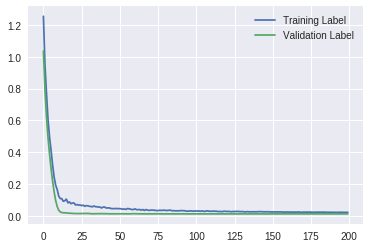

In [43]:
plt.plot(train_losses,label='Training Label')
plt.plot(val_losses,label='Validation Label')
plt.legend(frameon=False)

In [44]:

# initialize lists to monitor test loss and accuracy
test_loss = 0.0



model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)



# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)

print('Test Loss: {:.6f}\n'.format(test_loss))



Test Loss: 0.020842

